# Análisis de Datos de Accidentes de Tránsito en Monterrey

### Importaciones y Configuración

In [1]:

# Visualización
import matplotlib.pyplot as plt
import matplotlib as mpl
import scikitplot as skplt
import seaborn as sns
from pandas.plotting import autocorrelation_plot, lag_plot, andrews_curves
import shap
import prince
import folium
from folium import plugins
from folium.plugins import HeatMap

# Manupulación
import pandas_profiling
from sklearn import preprocessing
import pandas as pd
import numpy as np

# Algoritmos
from fbprophet import Prophet
from catboost import CatBoostClassifier
from catboost import *
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import KernelDensity
from sklearn.metrics import f1_score
import scipy.stats as stats
from catboost import Pool, cv
from sklearn.preprocessing import MinMaxScaler

# Otros
from tqdm import tqdm_notebook as tqdm
from random import shuffle
import shapefile
from itertools import cycle, islice
from cycler import cycler
import glob
import gc


In [2]:

tqdm().pandas()
pd.set_option("display.max_columns", 500)
shap.initjs()


In [3]:

# colores: https://matplotlib.org/examples/color/colormaps_reference.html
# https://matplotlib.org/examples/color/named_colors.html
# gráficas: https://informationisbeautiful.net/


### Métodos

In [4]:

def resalta_max(s):
    """
    Subraya la celda de un dataframe con el número más grande.
    """
    es_max = s == s.max()
    return ["background-color: yellow" if v else "" for v in es_max]


In [5]:

def promedio_coordenadas(estado):
    """
    Tupla con latitud y longitud del centro de masa de un estado.
    """
    coordenada = pd.Series(estado).apply(pd.Series).mean(axis=0)
    return coordenada.iloc[1], coordenada.iloc[0] # lat, long


In [6]:

def lee_shapefile(ruta):
    """
    Lee un archivo .sh (shapefile) con datos gemoétricos de coordenadas.
    Fuente: https://gist.github.com/aerispaha/f098916ac041c286ae92d037ba5c37ba
    """
    
    # Obtenemos las coordenadas.
    archivo_sh = shapefile.Reader(ruta)
    campos = [x[0] for x in archivo_sh.fields][1:]
    registros = archivo_sh.records()
    shps = [s.points for s in archivo_sh.shapes()]

    # Escribimos en un dataframe.
    df = pd.DataFrame(columns=campos, data=registros)
    df = df.assign(coords=shps)

    return df


In [7]:

def concat_involucrados(x):
    """
    Concatena tipos de vehículos involucrados en un siniestro. 
    """
    return x.values[0] if len(x) == 1 else "-".join([vehiculo for vehiculo in x])


In [8]:

def test_normalidad(datos):
    """
    Determina si una distribución es normal con prueba de hipótesis
    basada en D'Agostino.
    """
    k2, p = stats.normaltest(datos)
    alpha = 0.05
    print(f"p = {p}")

    # null hypothesis: x comes from a normal distribution
    if p < alpha: print("Rechazamos la hipótesis nula: La distribución no es normal.")
    else: print("No tenemos la suficiente evidencia para rechazar la hipótesis nula; puede que sea normal.")


In [9]:

def grafica_densidad(df_hombres, df_mujeres, etiqueta, lim_inf, lim_sup):
    """
    Grafica un kernel de un histograma para distribucion de edades hombre-mujer. 
    Fuente:
    https://github.com/admond1994/calculate-probability-from-probability-density-plots/blob/master/cal_probability.ipynb
    """
    plt.figure(figsize=(20, 8))

    params = {'xtick.labelsize': 20, 'ytick.labelsize': 20}
    plt.rcParams.update(params)
    
    unidad = 1.5
    x = np.linspace(df_hombres.min() - unidad, df_hombres.max() + unidad, 1000)[:, np.newaxis]

    # Graficamos los datos junto con el kernel.
    plt.hist(df_hombres, bins=10, density=True, label="Hombres", color="orange", alpha=0.2,)
    plt.hist(df_mujeres, bins=10, density=True, label="Mujeres", color="navy", alpha=0.2)
      
    mpl.rc('xtick', labelsize=20)     
    mpl.rc('ytick', labelsize=20)

    # Creamos la estimación del kernel.
    kd_hombres = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(df_hombres)
    kd_mujeres = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(df_mujeres)

    # Graficamos la densidad para cada punto.
    kd_vals_hombres = np.exp(kd_hombres.score_samples(x))
    kd_vals_mujeres = np.exp(kd_mujeres.score_samples(x))

    plt.plot(x, kd_vals_hombres, color="orange")
    plt.plot(x, kd_vals_mujeres, color="navy")
    
    plt.axvline(x=lim_inf,color="red",linestyle="dashed")
    plt.axvline(x=lim_sup,color="red",linestyle="dashed")

    # Mostramos las gráficas.
    plt.xlabel(etiqueta, fontsize=20)
    plt.ylabel("Densidad", fontsize=20)
    plt.legend(fontsize=20)
    plt.title("Comparación entre Géneros de Distribución de Edad en Accidentes Viales\nMonterrey 2010-2017", fontsize=20)
    plt.show()
    gc.collect()
    
    return kd_hombres, kd_mujeres


In [10]:

def calcula_probabilidad_kde(lim_inf, lim_sup, n_puntos, kd):
    """
    Probabilidad de un rango de edad.
    Fuente:
    https://github.com/admond1994/calculate-probability-from-probability-density-plots/blob/master/cal_probability.ipynb
    """                                  
    delta = (lim_sup - lim_inf) / (n_puntos - 1) 
    x = np.linspace(lim_inf, lim_sup, n_puntos)[:, np.newaxis]
    
    kd_vals = np.exp(kd.score_samples(x))  # Para cada punto se calcula una PDF. SKLearn regresa logs, por eso el exp.
    probabilidad = np.sum(kd_vals * delta)  # Aproximación numérica de la PDF.
    
    return probabilidad.round(4)


### Lectura de Datos

Nos interesan datos con una cobertura de 10 años (desde 2007 hasta 2017).

In [12]:

datos_mty = pd.read_csv("../datos/datos_limpios.csv")
datos_mty.head()


,ID_ENTIDAD,ID_MUNICIPIO,NOM_MUNICIPIO,NOM_ENTIDAD,COBERTURA,ANIO,MES,ID_HORA,ID_MINUTO,ID_DIA,DIASEMANA,TIPACCID,AUTOMOVIL,CAMPASAJ,MICROBUS,PASCAMION,OMNIBUS,TRANVIA,CAMIONETA,CAMION,TRACTOR,FERROCARRI,MOTOCICLET,BICICLETA,OTROVEHIC,CAUSAACCI,CAPAROD,SEXO,ALIENTO,CINTURON,ID_EDAD,CONDMUERTO,CONDHERIDO,PASAMUERTO,PASAHERIDO,PEATMUERTO,PEATHERIDO,CICLMUERTO,CICLHERIDO,OTROMUERTO,OTROHERIDO,NEMUERTO,NEHERIDO,CLASACC,ESTATUS,FECHA,RANGO_EDAD,ZONA,FECHA_COMPLETA,FECHA_DIF
0,19,21,General Escobedo,Nuevo León,Municipal,2007,1,0,0,1,Lunes,Colisión con objeto fijo,1,0,0,0,0,0,0,0,0,0,0,0,0,Conductor,Pavimentada,Hombre,Sí,Se ignora,41,0,1,0,0,0,0,0,0,0,0,0,0,No fatal,Cifras definitivas,2007-01-01 00:00:00,[35 - 45),Accidente en intersección,2007-01-01 00:00:00,NaN
1,19,26,Guadalupe,Nuevo León,Municipal,2007,1,0,17,1,Lunes,Colisión con vehículo automotor,1,0,0,0,0,0,1,0,0,0,0,0,0,Conductor,Pavimentada,Hombre,No,Se ignora,55,0,0,0,0,0,0,0,0,0,0,0,0,Sólo Daños,Cifras definitivas,2007-01-01 00:00:00,[45 - 55),Accidente en intersección,2007-01-01 00:17:00,0 days 00:17:00.000000000
2,19,26,Guadalupe,Nuevo León,Municipal,2007,1,1,24,1,Lunes,Colisión con vehículo automotor,2,0,0,0,0,0,0,0,0,0,0,0,0,Conductor,Pavimentada,Hombre,No,Se ignora,42,0,0,0,0,0,0,0,0,0,0,0,0,Sólo Daños,Cifras definitivas,2007-01-01 00:00:00,[35 - 45),Accidente en intersección,2007-01-01 01:24:00,0 days 01:07:00.000000000
3,19,19,San Pedro Garza García,Nuevo León,Municipal,2007,1,1,38,1,Lunes,Otro,1,0,0,0,0,0,0,0,0,0,0,0,1,Conductor,Pavimentada,Mujer,No,No,39,0,0,0,0,0,0,0,0,0,0,0,0,Sólo Daños,Cifras definitivas,2007-01-01 00:00:00,[35 - 45),Accidente en intersección,2007-01-01 01:38:00,0 days 00:14:00.000000000
4,19,46,San Nicolás de los Garza,Nuevo León,Municipal,2007,1,1,44,1,Lunes,Colisión con vehículo automotor,2,0,0,0,0,0,0,0,0,0,0,0,0,Conductor,Pavimentada,Hombre,Sí,Sí,27,0,1,0,1,0,0,0,0,0,0,0,0,No fatal,Cifras definitivas,2007-01-01 00:00:00,[25 - 35),Accidente en intersección,2007-01-01 01:44:00,0 days 00:06:00.000000000


### Pronóstico Serie de Tiempo

In [13]:

"""
Prophet was written to forecast time series data.
When pandas is imported, it overrides matplotlib's datetime plotting with pandas datetime plotting.
"""
pd.plotting.register_matplotlib_converters()


In [14]:

act_diaria = datos_mty.groupby(["ANIO", "MES", "ID_DIA"]).size().reset_index()
act_diaria["FECHA"] = pd.to_datetime(
    act_diaria["ANIO"].astype(str) + "-" + act_diaria["MES"].astype(str) + "-" + act_diaria["ID_DIA"].astype(str))
act_diaria.drop(["ANIO", "MES", "ID_DIA"], axis=1, inplace=True)
act_diaria.columns = ["n_accidentes", "fecha"]
act_diaria = act_diaria.iloc[:, ::-1]
act_diaria.head()


,fecha,n_accidentes
0,2007-01-01,98
1,2007-01-02,119
2,2007-01-03,177
3,2007-01-04,169
4,2007-01-05,150


In [16]:

anio_nuevo = pd.DataFrame({
  'holiday': 'anio_nuevo',
  'ds': pd.to_datetime(['2007-01-01', '2008-01-01', '2009-01-01',
                        '2010-01-01', '2011-01-01', '2012-01-01',
                        '2013-01-01', '2014-01-01', '2015-01-01',
                        '2016-01-01', '2017-01-01', '2018-01-01',
                        '2019-01-01', '2020-01-01']),
  'lower_window': 0,
  'upper_window': 1,
})
constitucion = pd.DataFrame({
  'holiday': 'Constitucion',
  'ds': pd.to_datetime(['2007-02-05', '2008-02-05', '2009-02-05',
                        '2010-02-05', '2011-02-05', '2012-02-05',
                        '2013-02-05', '2014-02-05', '2015-02-05',
                        '2016-02-05', '2017-02-05', '2018-02-05',
                        '2019-02-05', '2020-02-05']),
  'lower_window': 0,
  'upper_window': 1,
})
bj = pd.DataFrame({
  'holiday': 'natalicio',
  'ds': pd.to_datetime(['2007-03-21', '2008-03-21', '2009-03-21',
                        '2010-03-21', '2011-03-21', '2012-03-21',
                        '2013-03-21', '2014-03-21', '2015-03-21',
                        '2016-03-21', '2017-03-21', '2018-03-21',
                        '2019-03-21', '2020-03-21']),
  'lower_window': 0,
  'upper_window': 1,
})
trabajo = pd.DataFrame({
  'holiday': 'trabajo',
  'ds': pd.to_datetime(['2007-05-01', '2008-05-01', '2009-05-01',
                        '2010-05-01', '2011-05-01', '2012-05-01',
                        '2013-05-01', '2014-05-01', '2015-05-01',
                        '2016-05-01', '2017-05-01', '2018-05-01',
                        '2019-05-01', '2020-05-01']),
  'lower_window': 0,
  'upper_window': 1,
})
pue = pd.DataFrame({
  'holiday': 'pue',
  'ds': pd.to_datetime(['2007-05-05', '2008-05-05', '2009-05-05',
                        '2010-05-05', '2011-05-05', '2012-05-05',
                        '2013-05-05', '2014-05-05', '2015-05-05',
                        '2016-05-05', '2017-05-05', '2018-05-05',
                        '2019-05-05', '2020-05-05']),
  'lower_window': 0,
  'upper_window': 1,
})
madres = pd.DataFrame({
  'holiday': 'madres',
  'ds': pd.to_datetime(['2007-05-10', '2008-05-10', '2009-05-10',
                        '2010-05-10', '2011-05-10', '2012-05-10',
                        '2013-05-10', '2014-05-10', '2015-05-10',
                        '2016-05-10', '2017-05-10', '2018-05-10',
                        '2019-05-10', '2020-05-10']),
  'lower_window': 0,
  'upper_window': 1,
})
padre = pd.DataFrame({
  'holiday': 'padre',
  'ds': pd.to_datetime(['2007-06-21', '2008-06-21', '2009-06-21',
                        '2010-06-21', '2011-06-21', '2012-06-21',
                        '2013-06-21', '2014-06-21', '2015-06-21',
                        '2016-06-21', '2017-06-21', '2018-06-21',
                        '2019-06-21', '2020-06-21']),
  'lower_window': 0,
  'upper_window': 1,
})
indepe = pd.DataFrame({
  'holiday': 'indepe',
  'ds': pd.to_datetime(['2007-09-16', '2008-09-16', '2009-09-16',
                        '2010-09-16', '2011-09-16', '2012-09-16',
                        '2013-09-16', '2014-09-16', '2015-09-16',
                        '2016-09-16', '2017-09-16', '2018-09-16',
                        '2019-09-16', '2020-09-16']),
  'lower_window': 0,
  'upper_window': 1,
})
muertos = pd.DataFrame({
  'holiday': 'muertos',
  'ds': pd.to_datetime(['2007-11-01', '2008-11-01', '2009-11-01',
                        '2010-11-01', '2011-11-01', '2012-11-01',
                        '2013-11-01', '2014-11-01', '2015-11-01',
                        '2016-11-01', '2017-11-01', '2018-11-01',
                        '2019-11-01', '2020-11-01']),
  'lower_window': 0,
  'upper_window': 1,
})
rev = pd.DataFrame({
  'holiday': 'rev',
  'ds': pd.to_datetime(['2007-11-20', '2008-11-20', '2009-11-20',
                        '2010-11-20', '2011-11-20', '2012-11-20',
                        '2013-11-20', '2014-11-20', '2015-11-20',
                        '2016-11-20', '2017-11-20', '2018-11-20',
                        '2019-11-20', '2020-11-20']),
  'lower_window': 0,
  'upper_window': 1,
})
virgen = pd.DataFrame({
  'holiday': 'virgen',
  'ds': pd.to_datetime(['2007-12-12', '2008-12-12', '2009-12-12',
                        '2010-12-12', '2011-12-12', '2012-12-12',
                        '2013-12-12', '2014-12-12', '2015-12-12',
                        '2016-12-12', '2017-12-12', '2018-12-12',
                        '2019-12-12', '2020-12-12']),
  'lower_window': 0,
  'upper_window': 1,
})
noche = pd.DataFrame({
  'holiday': 'noche',
  'ds': pd.to_datetime(['2007-12-24', '2008-12-24', '2009-12-24',
                        '2010-12-24', '2011-12-24', '2012-12-24',
                        '2013-12-24', '2014-12-24', '2015-12-24',
                        '2016-12-24', '2017-12-24', '2018-12-04',
                        '2019-12-04', '2020-12-24']),
  'lower_window': 0,
  'upper_window': 1,
})
navidad = pd.DataFrame({
  'holiday': 'navidad',
  'ds': pd.to_datetime(['2007-12-25', '2008-12-25', '2009-12-25',
                        '2010-12-25', '2011-12-25', '2012-12-25',
                        '2013-12-25', '2014-12-25', '2015-12-25',
                        '2016-12-25', '2017-12-25', '2018-12-25',
                        '2019-12-25', '2020-12-25']),
  'lower_window': 0,
  'upper_window': 1,
})

festivos = pd.concat([
    navidad,
    noche,
    virgen,
    rev,
    muertos,
    indepe,
    padre,
    madres,
    pue,
    trabajo,
    bj,
    constitucion,
    anio_nuevo
],
axis=0
)
festivos.head()


,holiday,ds,lower_window,upper_window
0,navidad,2007-12-25,0,1
1,navidad,2008-12-25,0,1
2,navidad,2009-12-25,0,1
3,navidad,2010-12-25,0,1
4,navidad,2011-12-25,0,1


In [18]:
urbanos_prep

,ds,y
0,2007-01-01,98
1,2007-01-02,119
2,2007-01-03,177
3,2007-01-04,169
4,2007-01-05,150
5,2007-01-06,137
6,2007-01-07,92
7,2007-01-08,176
8,2007-01-09,162
9,2007-01-10,182


In [25]:
fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Constitucion,Constitucion_lower,Constitucion_upper,anio_nuevo,anio_nuevo_lower,anio_nuevo_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,indepe,indepe_lower,indepe_upper,madres,madres_lower,madres_upper,muertos,muertos_lower,muertos_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,natalicio,natalicio_lower,natalicio_upper,navidad,navidad_lower,navidad_upper,noche,noche_lower,noche_upper,padre,padre_lower,padre_upper,pue,pue_lower,pue_upper,rev,rev_lower,rev_upper,trabajo,trabajo_lower,trabajo_upper,virgen,virgen_lower,virgen_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2007-01-01,168.424309,84.316961,143.030785,168.424309,168.424309,1.0,1.0,1.0,0.951705,0.951705,0.951705,1.000443,1.000443,1.000443,0.951705,0.951705,0.951705,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.918806,0.918806,0.918806,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.004269,1.004269,1.004269,0.960902,0.960902,0.960902,1.0,1.0,1.0,109.111885
1,2007-01-02,168.385139,96.906817,158.781309,168.385139,168.385139,1.0,1.0,1.0,0.958571,0.958571,0.958571,1.000957,1.000957,1.000957,0.958571,0.958571,0.958571,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.938881,0.938881,0.938881,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.017872,1.017872,1.017872,0.961342,0.961342,0.961342,1.0,1.0,1.0,121.870715
2,2007-01-03,168.345977,116.413600,195.081255,168.345977,168.345977,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000937,1.000937,1.000937,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.979258,0.979258,0.979258,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.016669,1.016669,1.016669,0.962301,0.962301,0.962301,1.0,1.0,1.0,151.196702
3,2007-01-04,168.306825,112.098261,188.328009,168.306825,168.306825,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.999412,0.999412,0.999412,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.972802,0.972802,0.972802,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.009983,1.009983,1.009983,0.963753,0.963753,0.963753,1.0,1.0,1.0,146.122818
4,2007-01-05,168.267682,126.676690,211.670375,168.267682,168.267682,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.998632,0.998632,0.998632,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.994505,0.994505,0.994505,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.031277,1.031277,1.031277,0.965665,0.965665,0.965665,1.0,1.0,1.0,163.582078
5,2007-01-06,168.228547,111.406111,186.667385,168.228547,168.228547,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.999463,0.999463,0.999463,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.968580,0.968580,0.968580,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.001141,1.001141,1.001141,0.967996,0.967996,0.967996,1.0,1.0,1.0,142.836622
6,2007-01-07,168.189422,74.148191,123.786688,168.189422,168.189422,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000116,1.000116,1.000116,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.895831,0.895831,0.895831,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.922768,0.922768,0.922768,0.970695,0.970695,0.970695,1.0,1.0,1.0,95.708997
7,2007-01-08,168.150306,116.973686,193.932789,168.150306,168.150306,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000768,1.000768,1.00

In [ ]:
# No se aplica log porque los resultados son muy parecidos y sólo dificulta la interpretabilidad.
urbanos_prep = act_diaria.copy()
urbanos_prep.columns = ["ds", "y"]
urbanos_prep["ds"] = urbanos_prep["ds"].astype(str)

m = Prophet(
    growth="linear", # No parece haber un límite claro (genera un fit de modelos lineales picewise).
    changepoints=None, # Fechas de cambio abruptos (no hay alguna muy clara salvo la descartada).
    seasonality_mode="multiplicative", # Incrementos importantes en la población año con año.
    yearly_seasonality=True,
    daily_seasonality=False, # Especificaremos manualmente el detalle.
    weekly_seasonality=False, # Especificaremos manualmente el detalle.
    holidays=festivos
).add_seasonality(
    name="daily",
    period=16,
    fourier_order=5 # Controla el suavizamiento por Fourier (seno + coseno)
).add_seasonality(
    name="weekly",
    period=7,
    fourier_order=5
)

m.fit(urbanos_prep)
future = m.make_future_dataframe(periods=365*2, freq="D")
fcst = m.predict(future)

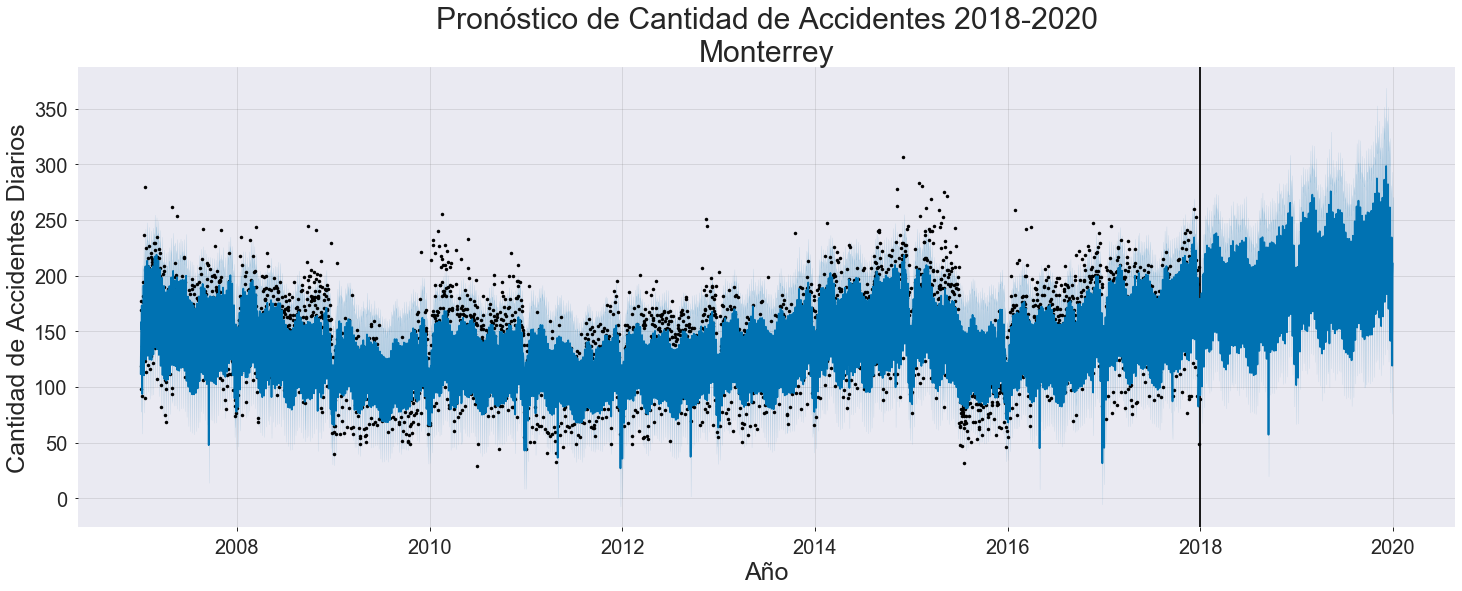

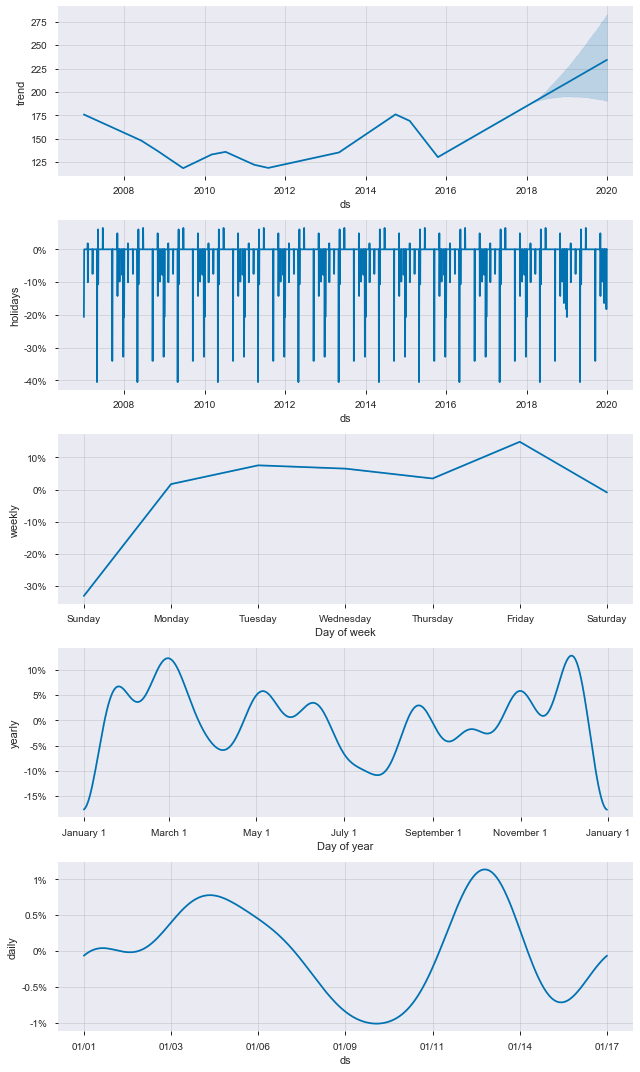

In [34]:

fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title("Pronóstico de Cantidad de Accidentes 2018-2020\nMonterrey", fontsize=30)
ax.axvline(x=pd.to_datetime("2018-01-01"), c="black")
fig_predicciones = m.plot(fcst, ax=ax)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel("Año", fontsize=25)
ax.set_ylabel("Cantidad de Accidentes Diarios", fontsize=25)
fig_components = m.plot_components(fcst)


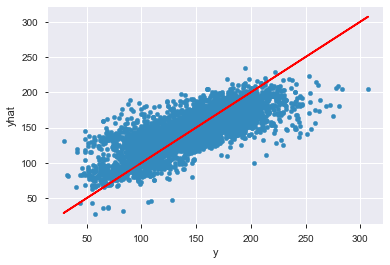

In [38]:

# Obtenemos errores usando Error Porcentual Medio Absoluto.
fcst["ds"] = fcst["ds"].astype(str)
errores = pd.merge(fcst, urbanos_prep, on='ds')
errores['MAPE'] = abs(errores["y"] - errores["yhat"]) / errores["y"]

errores.plot.scatter('y', 'yhat')
plt.plot(errores["y"], errores["y"], color='red')
plt.show()


count    4018.000000
mean        0.170903
std         0.199177
min         0.000012
25%         0.056428
50%         0.120748
75%         0.210207
max         3.498094
Name: MAPE, dtype: float64

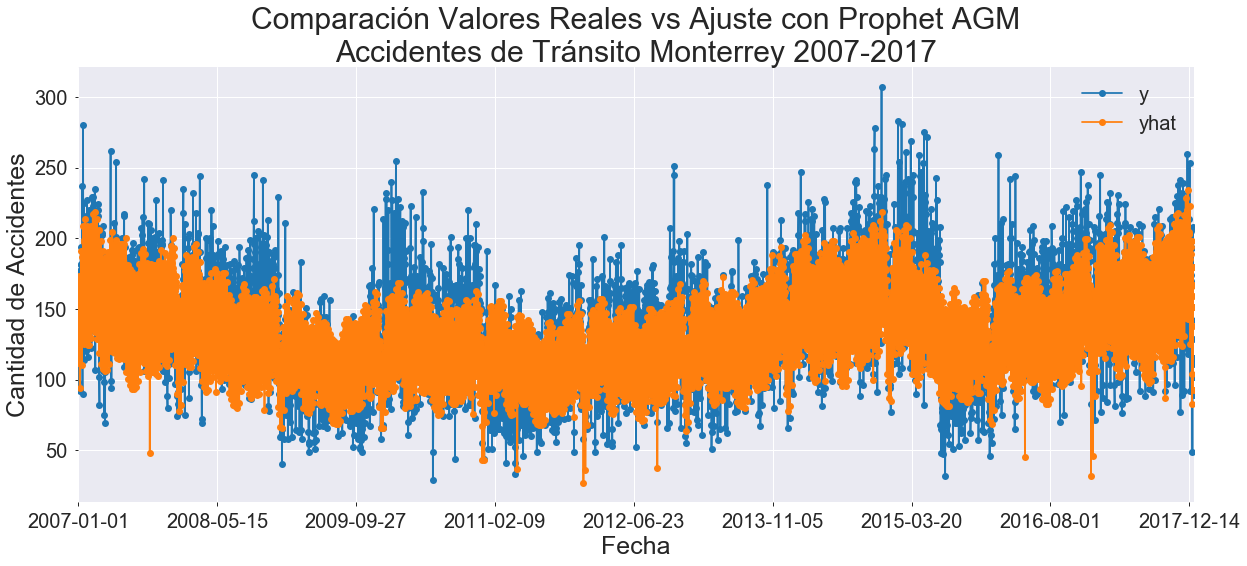

In [43]:

# Los errores son porcentajes
display(errores["MAPE"].describe())
errores.plot(
    x='ds',
    y=['y', 'yhat'],
    style='-o',
    figsize=(20,8),
    fontsize=20
)
plt.legend(["y", "yhat"], fontsize=20)
plt.xlabel("Fecha", fontsize=25)
plt.ylabel("Cantidad de Accidentes", fontsize=25)
plt.title("Comparación Valores Reales vs Ajuste con Prophet AGM\nAccidentes de Tránsito Monterrey 2007-2017", fontsize=30)
plt.show()
